1. Process data into pickles with skip 40
2. Load this in to df dataloader
3. Train simple MLP map o -> a, observe it being okay
4. Get play subsequences, do goal conditioned BC, not just BC
5. LFP planner/encoder
6. Label a couple subsequences w/ language, and map that to the z space!

# Data Creation

In [ ]:
import data
# data.build_dataset_from_mjl('../relay-policy-learning')

# Dataset

In [ ]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random

In [ ]:
observations, actions, cnt = data.create_single_dataset('../relay-policy-learning', batch_size=1)

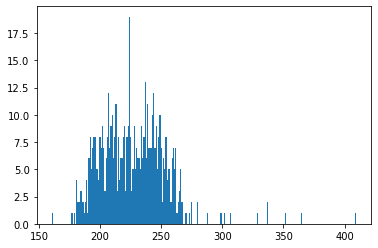

In [3]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

# Model

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input

## Simple MLP Baseline
Use this to map obs -> act

In [70]:
model = Sequential(
    [
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(9 , activation=None),
    ],
    name = 'mlp_baseline'
)

# Training Loop

In [71]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar

import time

In [72]:
# Instantiate an optimizer to train the model.
optimizer = Adam(learning_rate=1e-4)
# Instantiate a loss function.
loss_fn = MeanSquaredError()

# Prepare the metrics.
# train_acc_metric = Accuracy()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [74]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    


Epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1/565 [..............................] - ETA: 2:46 - Loss: 0.2236WARNING:tensorflow:5 out of the last 5 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  7/565 [..............................] - ETA: 1:06 - Loss: 0.2273WARNING:tensorflow:8 out of the last 8 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 12/565 [..............................] - ETA: 1:01 - Loss: 0.2245WARNING:tensorflow:11 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 19/565 [>.............................] - ETA: 55s - Loss: 0.2090 WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 28/565 [>.............................] - ETA: 48s - Loss: 0.1998WARNING:tensorflow:8 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 34/565 [>.............................] - ETA: 47s - Loss: 0.1960WARNING:tensorflow:9 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 41/565 [=>............................] - ETA: 45s - Loss: 0.1879WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 50/565 [=>............................] - ETA: 42s - Loss: 0.1790WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 58/565 [==>...........................] - ETA: 40s - Loss: 0.1715WARNING:tensorflow:9 out of the last 14 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 66/565 [==>...........................] - ETA: 39s - Loss: 0.1668WARNING:tensorflow:9 out of the last 13 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 77/565 [===>..........................] - ETA: 36s - Loss: 0.1622WARNING:tensorflow:6 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 87/565 [===>..........................] - ETA: 34s - Loss: 0.1583WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 94/565 [===>..........................] - ETA: 34s - Loss: 0.1555WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


131/565 [=====>........................] - ETA: 24s - Loss: 0.1471WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


161/565 [=======>......................] - ETA: 20s - Loss: 0.1430WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


183/565 [========>.....................] - ETA: 17s - Loss: 0.1403WARNING:tensorflow:5 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


565/565 [==============================] - 10s 19ms/step - Loss: 0.1199

Epoch 1
565/565 [==============================] - 0s 615us/step - Loss: 0.0969

Epoch 2
565/565 [==============================] - 0s 635us/step - Loss: 0.0876

Epoch 3
565/565 [==============================] - 0s 604us/step - Loss: 0.0812

Epoch 4
565/565 [==============================] - 0s 616us/step - Loss: 0.0763

Epoch 5
565/565 [==============================] - 0s 634us/step - Loss: 0.0722

Epoch 6
565/565 [==============================] - 0s 620us/step - Loss: 0.0688

Epoch 7
565/565 [==============================] - 0s 615us/step - Loss: 0.0659

Epoch 8
565/565 [==============================] - 0s 646us/step - Loss: 0.0631

Epoch 9
565/565 [==============================] - 0s 676us/step - Loss: 0.0607

Epoch 10
565/565 [==============================] - 0s 641us/step - Loss: 0.0586

Epoch 11
565/565 [==============================] - 0s 603us/step - Loss: 0.0568

Epoch 12
565/565 [================

In [80]:
model.summary()

Model: "mlp_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  7808      
_________________________________________________________________
dense_7 (Dense)              multiple                  8256      
_________________________________________________________________
dense_8 (Dense)              multiple                  585       
Total params: 16,649
Trainable params: 16,649
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.predict(tf.random.normal((1,200,60))).shape

(1, 200, 9)

# Evaluation

In [75]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim


In [76]:
i = 0
test_obs, test_act = observations[i], actions[i]
test_obs.shape

(225, 60)

In [79]:
env.reset()
env.robot.reset(env, test_obs[0,:30], test_obs[0,30:])
pred_act = model.predict(tf.expand_dims(test_obs,0))
for i in range(len(test_obs)):

    env.step(pred_act[0,i]) # the key change
    env.render()